##  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Set Seaborn style
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#f0f0f0"})

## Load Data and Model

In [2]:
# Load engineered data (from Day 2)
df = pd.read_csv("SMH_Engineered_Data.csv", parse_dates=["Date"], index_col="Date")

# Load the trained XGBoost model (from Day 3)
best_model = joblib.load("best_xgboost_model.pkl")

## Prepare Data for Backtesting

In [3]:
# Recreate the target variable (for alignment)
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
df.dropna(subset=["Target"], inplace=True)

# Split into features (X) and target (y)
X = df.drop("Target", axis=1)
y = df["Target"]

# Use the same 80-20 split as Day 3
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

## Generate Predictions for Test Data

In [4]:
# Predict probabilities and classes
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (price up)
y_pred = best_model.predict(X_test)

# Add predictions to the test dataframe
test_df = X_test.copy()
test_df["Actual_Return"] = df["Close"].pct_change().shift(-1).iloc[train_size:]  # Next-day returns
test_df["Predicted_Signal"] = y_pred
test_df.dropna(inplace=True)

## Implement Backtesting Logic

In [5]:
def backtest_strategy(data, initial_capital=1000, transaction_cost=0.001):
    capital = initial_capital
    position = 0  # 0 = out of market, 1 = long
    portfolio_value = []
    trades = []
    
    for i in range(len(data)):
        current_price = data["Close"].iloc[i]
        signal = data["Predicted_Signal"].iloc[i]
        
        # Buy signal (enter long)
        if signal == 1 and position == 0:
            position = 1
            shares = (capital * (1 - transaction_cost)) / current_price  # Account for transaction cost
            capital = 0
            trades.append(("Buy", data.index[i], current_price))
        
        # Sell signal (exit long)
        elif signal == 0 and position == 1:
            position = 0
            capital = shares * current_price * (1 - transaction_cost)  # Account for transaction cost
            shares = 0
            trades.append(("Sell", data.index[i], current_price))
        
        # Track portfolio value
        if position == 1:
            portfolio_value.append(shares * current_price)
        else:
            portfolio_value.append(capital)
    
    # Convert to DataFrame
    results = pd.DataFrame({
        "Date": data.index,
        "Portfolio_Value": portfolio_value,
        "Position": [position] * len(data)
    })
    return results, trades

# Run backtest
backtest_results, trades = backtest_strategy(test_df)

## Calculate Performance Metrics

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Total return
initial_value = 1000
final_value = backtest_results["Portfolio_Value"].iloc[-1]
total_return_pct = (final_value / initial_value - 1) * 100

# Win rate (profitable trades)
trade_results = []
for i in range(1, len(trades)):
    if trades[i][0] == "Sell":
        entry_price = trades[i-1][2]
        exit_price = trades[i][2]
        trade_return = (exit_price - entry_price) / entry_price
        trade_results.append(trade_return)

win_rate = (np.array(trade_results) > 0).mean() * 100

# Print metrics
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Number of Trades: {len(trades) // 2}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Final Portfolio Value: ${final_value:.2f}")

# Confusion Matrix (optional)
print("\nClassification Metrics:")
print(classification_report(y_test, y_pred))

Total Return: -0.80%
Number of Trades: 28
Win Rate: 60.71%
Final Portfolio Value: $992.03

Classification Metrics:
              precision    recall  f1-score   support

           0       0.46      0.56      0.51       365
           1       0.50      0.39      0.44       395

    accuracy                           0.48       760
   macro avg       0.48      0.48      0.47       760
weighted avg       0.48      0.48      0.47       760



## Visualize Portfolio Performance

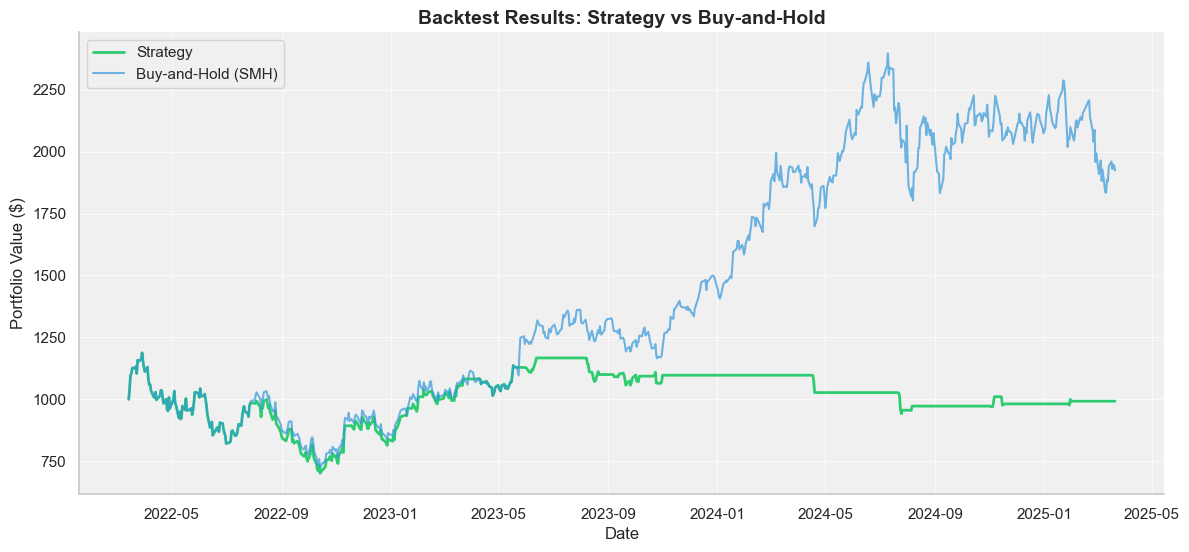

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(backtest_results["Date"], backtest_results["Portfolio_Value"], color="#2ecc71", linewidth=2, label="Strategy")
plt.plot(test_df["Close"] / test_df["Close"].iloc[0] * 1000, color="#3498db", alpha=0.7, label="Buy-and-Hold (SMH)")
plt.title("Backtest Results: Strategy vs Buy-and-Hold", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True, color="white", linestyle="-", linewidth=0.5)
plt.gca().set_facecolor("#f0f0f0")
sns.despine()
plt.show()

## Save Backtest Results

In [9]:
backtest_results.to_csv("SMH_Backtest_Results.csv", index=False)
print("Backtest results saved to 'SMH_Backtest_Results.csv'")

Backtest results saved to 'SMH_Backtest_Results.csv'
